In [9]:
# imports
import numpy as np
from scipy.integrate import ode
%matplotlib inline
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

# import xflib
# xf = xflib.xflib(lib_path='/Users/austin/python_local/libxformd.so')

import matplotlib.gridspec as gridspec

from tempfile import NamedTemporaryFile
import base64 
from matplotlib import animation
VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

from mpl_toolkits.basemap import Basemap

import gzip
import pickle


Bc is: [  1.25663518e-06   0.00000000e+00   0.00000000e+00]
left field is: [ 628.3185308    0.           0.       ]
Calculating plot...


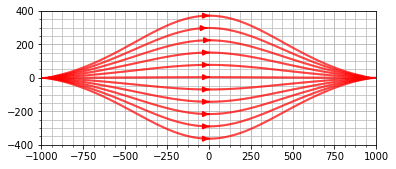

In [82]:
# Calculate magnetic field vector:

# current loop 
import loopfield as lf

import loopfieldplot as lfp

# field object
field = lf.Field(length_units = lf.km,
                 current_units = lf.A,
                 field_units = lf.T)


# Helmholtz coil model with single current loops

# single-turn 10 cm x-oriented coil at origin
p1 = [-1000., 0., 0.]
p2 = [ 1000., 0., 0.]
normal = [1., 0., 0.]
radius = 1.
current = 1e12
c1 = lf.Loop(p1, normal, radius, current)
c2 = lf.Loop(p2, normal, radius, current)

# add windings to field
field.addLoop(c1)
field.addLoop(c2)

# get field strength at center:
Bc = field.evaluate(np.array([0,0,0]))
print "Bc is:", Bc

# get field strength at ring:
Bleft = field.evaluate(np.array([-1000,0,0]))
print "left field is:", Bleft
print('Calculating plot...')


# create XY plot
min_x = -1000
max_x = +1000
min_y = -400
max_y = +400
n_x = 101
n_y = 101

n_lines = 11
density = 20
X = np.linspace(min_x, max_x, n_x)
Y = np.linspace(min_y, max_y, n_y)
B = np.empty([n_y*n_x, 3])

# Evaluate field at grid coordinates
for i in range(0, n_y):
    for j in range(0, n_x):
        B[n_x * i + j, :] = field.evaluate(np.array([X[j],Y[i],0.]))


fig, ax = plt.subplots(1,1)

ax.set_aspect('equal')
ax.grid(b = True, which = 'major')
ax.grid(b = True, which = 'minor', color="0.75")
ax.minorticks_on()
ax.set_ylim([min_y, max_y])
ax.set_xlim([min_x, max_x])

# Add fieldlines

start_points = np.array([np.zeros(n_lines),
    min_y + (max_y - min_y) *
    (0.5 + np.linspace(0, n_lines-1, n_lines)) /
    (n_lines)]).transpose()

strm = ax.streamplot(X, Y,
      np.reshape(B[:, 0], [n_y, n_x]),
      np.reshape(B[:, 1], [n_y, n_x]),
      linewidth = 2, density = density,
      color="r",
      arrowsize = 1.,
      start_points = start_points)





# # # add field lines
# plot.fieldLines()


# # # add loop symbols
# plot.loopSymbols(scale = 1.)

# # add circled area hand-adjusted to fit in 1% error volume "octopus"
# center_r = 3.2
# plot.circle([0., 0.], radius = center_r, color='blue', alpha=0.5,
#             label = ('r = %2.1f cm' % center_r))


# fig.set_ylim([-20,20])
# # add text
# plot.labels(title = '10cm Helmholtz Coil',
#             xlabel = 'x (cm)', ylabel = 'y (cm)')




In [83]:
# Next -- redo with background B field as a vector:

def newton(t, Y, q, m, B):
    
    """Computes the derivative of the state vector y according to the equation of motion:
    Y is the state vector (x, y, z, u, v, w) === (position, velocity).
    returns dY/dt.
    This version takes B as a vector.
    """
    x, y, z = Y[0], Y[1], Y[2]
    u, v, w = Y[3], Y[4], Y[5]
    
    dv = np.cross(Y[3:6], B)*q / m
    alpha = q / m * np.linalg.norm(B)
    
#     print "orig:", [0, alpha * w, -alpha * v]
#     print "vect:", dv
#     return np.array([u, v, w, 0, alpha * w, -alpha * v])
    return np.array([u, v, w, dv[0], dv[1], dv[2]])

initial field strength is 0.249451 uT
Gyrofrequency is 275.922 MHz
Gyroradius is 56.4374 km
(2000, 3)


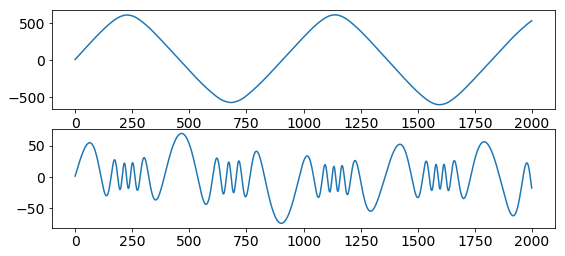

In [293]:
R2D = 180.0/np.pi
D2R = np.pi/180.0
R_E = 6371.

# Let's do it totally realistically:
q = -1.602e-19
m = (9.1e-31)
c = 2.99e8
E_EL = 5.105396765648739e5
ke = 150           # electron energy in ev
alpha = 20        # equatorial pitch angle

dt = 5e-7 # timestep 
t0 = dt # start time
t1 = 1e-3 # stop time


# Magnetic field
import loopfield as lf
# import loopfieldplot as lfp

# field object
field = lf.Field(length_units = lf.km,
                 current_units = lf.A,
                 field_units = lf.T)

# Two coils to make a magnetic bubble trap

separation = 2000 # km
p1 = [-separation/2., 0., 0.]
p2 = [ separation/2., 0., 0.]
normal = [1., 0., 0.] # Pointing along x axis
radius = 1. 
current = 2e11 # loop current
c1 = lf.Loop(p1, normal, radius, current)
c2 = lf.Loop(p2, normal, radius, current)

# add windings to field
field.addLoop(c1)
field.addLoop(c2)

# Initial velocity (relativistic correction if needed)
vtot = c*np.sqrt(1 - pow( (E_EL/(E_EL+ke)),2))

# Starting position and velocity vectors
x0 = np.array([0,0,-50])  # start in center
v0 = np.array([np.cos(alpha*D2R), np.sin(alpha*D2R), 0])*vtot
initial_conditions = np.concatenate((x0, v0))

# calculate basic parameters:
# Starting field
B0 = field.evaluate(x0)
print "initial field strength is %g uT"%(np.linalg.norm(B0)*1e6)
# initial gyrofrequency:
wc = np.abs(q*np.linalg.norm(B0)/m)
print "Gyrofrequency is %g MHz"%(wc*2.*np.pi*1e-3)
# initial gyroradius:
rl = vtot*np.sin(alpha*D2R)/wc
print "Gyroradius is %g km"%(rl)

#  Start the integrator
r = ode(newton).set_integrator('dopri5')
r.set_initial_value(initial_conditions, t0).set_f_params(q, m, B0)

positions = []
Bnorms = []
while r.successful() and r.t < t1:
    r.integrate(r.t+dt)
    positions.append(r.y[:3]) # keeping only position, not velocity
    
    xcur = r.y[:3]
    Bcar = field.evaluate(xcur)
    r.set_f_params(q, m, Bcar)
    Bnorms.append(np.linalg.norm(Bcar))

positions = np.array(positions)
Bnorms = np.array(Bnorms)
print np.shape(positions)

fig, ax = plt.subplots(2,1)
ax[0].plot(positions[:,0])
ax[1].plot(positions[:,1])

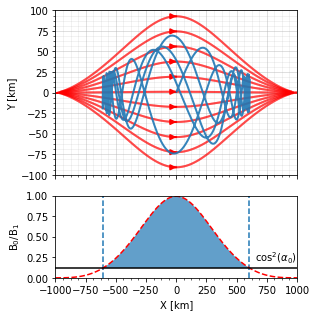

In [337]:

# --------------- Latex Plot Beautification --------------------------
fig_width = 3.5 
fig_height = 3.5
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 10,
          'font.size': 10,
          'legend.fontsize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

# create XY plot
min_x = -1000
max_x = +1000
min_y = -100
max_y = +100
n_x = 101
n_y = 101

n_lines = 11
density = 20
X = np.linspace(min_x, max_x, n_x)
Y = np.linspace(min_y, max_y, n_y)
B = np.empty([n_y*n_x, 3])

# Evaluate field at grid coordinates
for i in range(0, n_y):
    for j in range(0, n_x):
        B[n_x * i + j, :] = field.evaluate(np.array([X[j],Y[i],0.]))


fig, ax = plt.subplots(2,1, sharex=True, gridspec_kw={'height_ratios':[2,1]})
# fig, ax = plt.subplots(1,2, sharex=True)


# ax.set_aspect('equal')
ax[0].grid(b = True, which = 'major', alpha=0.5)
ax[0].grid(b = True, which = 'minor', alpha=0.2)
ax[0].minorticks_on()
ax[0].set_ylim([min_y, max_y])
ax[0].set_xlim([min_x, max_x])

# Add fieldlines

start_points = np.array([np.zeros(n_lines),
    min_y + (max_y - min_y) *
    (0.5 + np.linspace(0, n_lines-1, n_lines)) /
    (n_lines)]).transpose()

strm = ax[0].streamplot(X, Y,
      np.reshape(B[:, 0], [n_y, n_x]),
      np.reshape(B[:, 1], [n_y, n_x]),
      linewidth = 2, density = density,
      color="r",
      arrowsize = 1.,
      start_points = start_points)

# Add particle trajectory:

ax[0].plot(positions[:,0], positions[:,1], linewidth=2, alpha=0.9, label='Trajectory')


# ax[0].set_xlabel('X [km]')
ax[0].set_ylabel('Y [km]')

Bnorms_along_x = []
for x in X:
    Bnorms_along_x.append(np.linalg.norm(field.evaluate([x,0,0])))

ratios = np.linalg.norm(B0)/Bnorms_along_x
# ax[1].plot(positions[:,0], np.linalg.norm(B0)/Bnorms, alpha=0.5)
ax[1].plot([np.min(positions[:,0]), np.min(positions[:,0])], [0,1], c=plt.cm.Vega10(0), linestyle='--')
ax[1].plot([np.max(positions[:,0]), np.max(positions[:,0])], [0,1], c=plt.cm.Vega10(0), linestyle='--')
ax[1].plot(X, ratios, 'r--')

ax[1].set_ylim([0,1])

Y1 = pow(np.sin(alpha*D2R),2)*np.ones_like(X)
Y2 = ratios

ax[1].plot(X, Y1, 'k-')
ax[1].text(650, 0.2,r'cos$^2$($\alpha_0)$')

ax[1].fill_between(X, Y1, Y2, where=Y1 <= Y2, facecolor=plt.cm.Vega10(0), interpolate=True, alpha=0.7)
ax[1].set_xlabel('X [km]')
ax[1].set_ylabel('B$_0$/B$_1$')

fig.tight_layout()

fig.savefig('bubble.pdf')

In [283]:
print np.shape(Y2)

(101, 3)


['lat', 'lon']


NameError: name 'positions' is not defined

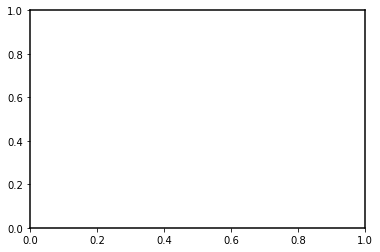

In [38]:
with gzip.open('mag_coastlines.gzip','rb') as file:
    coast = pickle.load(file)
print coast.keys()

fig, ax = plt.subplots(1,1)
[i.set_linewidth(1.5) for i in ax.spines.itervalues()]
ax.plot(positions[:,0], positions[:,2], linewidth=2)
ax.set_aspect('equal')
ax.set_xlim([0,L + 0.5])
ax.set_ylim(np.array([-1, 1])*(L + 0.5)/2.)
ax.set_yticks([ -1, 0, 1])
# Draw the earth
# Plot the earth
earth = plt.Circle((0,0),1,facecolor='0.6',alpha=1,edgecolor='k', zorder=100)
iono  = plt.Circle((0,0),1 + 1000./6378.,alpha=0.3, zorder=99)
 
ax.add_patch(earth)                    # The earth (round)
ax.add_patch(iono)
coastpoints = np.vstack([coast['lon']/90. + 0.3, coast['lat']/90.])
coastr = np.linalg.norm(coastpoints, axis=0)
coastmask = (coastr < 1) | (np.isnan(coastr))
ax.plot(coastpoints[0,coastmask], coastpoints[1,coastmask],'k', zorder=101, alpha=0.6)



# ax2=fig.add_axes([0,0.25,0.52,0.5])
# m = Basemap(projection='ortho',lon_0=-105,lat_0=-25,resolution='l',ax=ax2)
# m.bluemarble(scale=.5) # scale=.1 for low resolution

# Plot latitude lines:

for la in np.arange(-80, 81, 10):
    rr = np.array([1,10])
    plt.plot(rr*np.cos(la*D2R), rr*np.sin(la*D2R),'--',color='grey', alpha=0.3)
    

# Plot the fieldlines
lam = np.linspace(-80,80,181)
L_r = L*pow(np.cos(lam*D2R),2)
Lx  = L_r*np.cos(lam*D2R)
Ly  = L_r*np.sin(lam*D2R)
ax.plot(Lx,Ly,color='r',linewidth=2,linestyle='dashed')  # Field line

In [369]:
# Try it with a kinked field line:
# --------------- Latex Plot Beautification --------------------------
fig_width = 9 
fig_height = 6
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'font.size': 14,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------
r = ode(newton).set_integrator('dopri5')
q = -1
m = 1
Bo = 7

pert_mag = 0.02 #0.15


t1 = 12
dt = 1e-2



R2D = 180.0/np.pi
D2R = np.pi/180.0
R_E = 6371.
alpha = 45 # starting pitch angle
wave = 'circular'

x0 = [0,-0.1,-5]
v0 = np.array([np.sin(alpha*D2R), 0, np.cos(alpha*D2R)])
initial_conditions = np.concatenate((x0, v0))

B_background = np.array([0,0,Bo])
Bcur = B_background

pert_length = 1.8
r.set_initial_value(initial_conditions, t0).set_f_params(q, m, B)

positions = []
velocities = []
Bvecs = []
pitch_angles = []
total_velocity = []
vperps = []
vpars = []
perturbation = []

maxx=0; maxy=0;
while r.successful() and r.t < t1:
    r.integrate(r.t+dt)
    
    # Keep track of the maximum extent of the x and y planes
    maxx = max(maxx, r.y[0])
    maxy = max(maxy, r.y[1])
    
    if (r.y[2] > -pert_length) and (r.y[2] < pert_length):
        if wave in 'circular':
            # Resonant perturbation (circular):
            pert_dir = np.cross(r.y[3:6], B_background)
            pert_dir /= np.linalg.norm(pert_dir)
        elif wave in 'plane_in_phase':
            # Resonant perturbation (plane wave)
            pert_dir = np.array([0, r.y[1], 0])/maxy
        elif wave in 'plane_out_of_phase':
            # Resonant perturbation (plane wave, out of phase)
            pert_dir = np.array([0, r.y[0], 0])/maxx

        Bcur = B_background + Bo*pert_mag*pert_dir

        perturbation.append(pert_mag*pert_dir)
    else:
        perturbation.append(np.array([0,0,0]))
        Bcur = np.array([0, 0, Bo])
    r.set_f_params(q, m, Bcur)
    
    positions.append(r.y[:3]) # keeping only position, not velocity
    velocities.append(r.y[3:])

    Bvecs.append(Bcur)
    vperp = np.linalg.norm(np.cross(r.y[3:6],Bcur))/np.linalg.norm(Bcur)
    vpar  = np.dot(r.y[3:6],Bcur)/np.linalg.norm(Bcur)
    pitch_angles.append(np.arctan2(vperp, vpar)*R2D)
    total_velocity.append(vperp**2. + vpar**2.)
    vperps.append(vperp)
    vpars.append(vpar)

vperps = np.array(vperps)
vpars = np.array(vpars)
velocities = np.array(velocities)
positions = np.array(positions)
Bvecs = np.array(Bvecs)
perturbation = np.array(perturbation)

In [370]:
zlims = [-5, 5]
xylims = [-0.1, 0.1]
n_frames = 200

bangle = np.arccos(np.dot(Bvecs, B_background)/np.linalg.norm(Bvecs, axis=1)/np.linalg.norm(B_background))*R2D
force_dir = (q/m)*np.cross(velocities, Bvecs)
fig = plt.figure()
gs = gridspec.GridSpec(1,4,width_ratios=[2.5,1,1,1])

ax0 = plt.subplot(gs[0], projection='3d')
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])


def plt_init():
    # fig.patch.set_facecolor('black')
    ax0.set_facecolor((0.2,0.2,0.2))
    ax0.view_init(10, 0)
    ax0.axis('off')
    ax0.set_xlim(xylims)
    ax0.set_ylim(xylims)
    ax0.set_zlim(-3,3)

    ax1.set_ylim(zlims)
    ax1.set_yticks([])
    ax1.set_xlim([10,80])
    ax1.set_xticks(np.arange(10, 51, 10))
    ax1.set_xlabel('Pitch angle (deg)')
    ax1.grid('on', which='both')

    ax2.set_ylim(zlims)
    ax2.set_yticks([])
    ax2.set_xticks([-1.5, -1, -0.5, 0, 0.5, 1, 1.5])
    ax2.set_xlim([-0.2, 1.5])
    ax2.set_xlabel('B-field Angle (deg)')
    ax2.grid('on', which='both')

    ax3.set_xlim([0,1.5])
    ax3.set_xticks([0, 0.5, 1, 1.5])
    ax3.set_ylim(zlims)
    ax3.grid('on', which='both')
    ax3.legend()
    ax3.set_yticks([])
    ax3.set_xlabel('Velocity')


    fig.tight_layout()
    
tvec = np.linspace(0,len(positions)-1,n_frames, dtype=int)
def anim_frame(k):
    t = tvec[k]
    yax = positions[0:t,2]
    
    ax0.cla()
    ax0.plot([0,0],[0,0],zlims,'r', linewidth=2)
    ax0.plot(positions[0:t,0], positions[0:t,1], positions[0:t,2],'w-', linewidth=2)
    ax0.scatter(positions[t,0], positions[t,1], positions[t,2], c='w', s=60)
    
#     force_vec = np.vstack([positions[t,:], positions[t,:] + 0.05*force_dir[t,:]/np.linalg.norm(force_dir[t,:])])

#     ax0.plot(force_vec[:,0], force_vec[:,1], force_vec[:,2],'c', linewidth=2)
    ax0.plot([0, 3*perturbation[t,0]],
             [0, 3*perturbation[t,1]],
             [positions[t,2], positions[t,2] + perturbation[t,2]], 'c', linewidth=3)
    ax0.set_facecolor((0.2,0.2,0.2))
    ax0.view_init(10, 0)
    ax0.axis('off')
    ax0.set_xlim(xylims)
    ax0.set_ylim(xylims)
    ax0.set_zlim(-3,3)


    ax1.cla()
    ax1.plot(pitch_angles[0:t], yax, 'b',linewidth=2)
    ax1.set_ylim(zlims)
    ax1.set_yticks([])
    ax1.set_xlim([10,80])
    ax1.set_xticks([10, 45, 80])
    ax1.set_xlabel('Pitch angle (deg)')
    ax1.grid('on', which='both')

    ax2.plot(bangle[0:t], yax, 'r', linewidth=2)

    ax3.cla()
    ax3.plot(vpars[0:t], yax,'r', linewidth=2, label = 'v$_\parallel$')
    ax3.plot(vperps[0:t], yax, 'b--', linewidth=2, label = 'v$_\perp$')
    ax3.plot(np.linalg.norm(velocities, axis=1)[0:t], yax, 'c', linewidth=2, label='v$_{tot}$')
    ax3.set_xlim([0,1.5])
    ax3.set_xticks([0, 0.5, 1, 1.5])
    ax3.set_ylim(zlims)
    ax3.grid('on', which='both')
    ax3.legend()
    ax3.set_yticks([])
    ax3.set_xlabel('Velocity (rel)')

#     ax1.set_title('Plane Wave (out of phase)')
#     ax1.set_title('Plane Wave (in phase)')
#     ax1.set_title('Circularly-Polarized Wave')
# call the animator.
anim = animation.FuncAnimation(fig, anim_frame, init_func=plt_init,
                               frames=n_frames, interval=1)

# call our new function to display the animation
display_animation(anim)    
    

/var/folders/yn/zqfgwpp155d3hrbfdx_7xlpm0000gn/T/tmpRrtiYF.mp4


0.815182000708 0.0
1.65280440453 1.65280440453


In [37]:
# Let's do it totally realistically:
q = -1.602e-19
m = 9.1e-31
B0 = 30e-6

r2d = 180.0/np.pi
d2r = np.pi/180.0
R_E = 6371.
import numpy as np
from numpy import arctan2, sqrt
# import numexpr as ne

def spherical_to_cartesian(r_in):
    x = r_in[0]*np.cos(d2r*r_in[1])*np.cos(d2r*r_in[2])
    y = r_in[0]*np.cos(d2r*r_in[1])*np.sin(d2r*r_in[2])
    z = r_in[0]*np.sin(d2r*r_in[1])
    #print x, y, z
    return np.array([x, y, z]).T

def cartesian_to_spherical(x_in):
    ''' cartesian to spherical (degrees)'''
    rads = np.linalg.norm(x_in,axis=0)
    lons = r2d*np.arctan2(x_in[1], x_in[0]);
    lats = r2d*np.arcsin(x_in[2]/rads)
    return np.array([rads, lats, lons]).T

def bfield(x_in):
    Bo = (3.12e-5)
    D2R = np.pi/180.
    R_E = 6371e3;

    R = x_in[0]
    theta = (90. - x_in[1])*D2R
    phi   = x_in[2]*D2R
    
    Bor3  = Bo*pow(R, -3.0)
    
    Brad = -2.0*Bor3*np.cos(theta);
    Btheta = -1.0*Bor3*np.sin(theta);
    Bphi = 0.0;    # Dipole model has no variation in longitude (here for completeness)

    B_out = np.zeros(3)
    B_out[0] = Brad;        # Up
    B_out[1] = Btheta;      # South
    B_out[2] = Bphi;        # East

    return B_out
def transform_data_sph2car(lat, lon, d_in):
    D2R = np.pi/180.

    M = np.zeros([3,3])
    d_out = np.zeros(3)

    theta = D2R*(90. - lat)
    phi   = D2R*lon

    st = np.sin(theta)
    sp = np.sin(phi)
    ct = np.cos(theta)
    cp = np.cos(phi)

    M[0,0] = st*cp;    M[0,1] = ct*cp;   M[0,2] = -sp;
    M[1,0] = st*sp;    M[1,1] = ct*sp;   M[1,2] = cp;
    M[2,0] = ct;       M[2,1] = -st;     M[2,2] = 0;

    d_out = np.dot(M, d_in)

    return d_out

def transform_data_car2sph(lat, lon, d_in):
    D2R = np.pi/180.

    M = np.zeros([3,3])
    d_out = np.zeros(3)

    theta = D2R*(90. - lat)
    phi   = D2R*lon

    st = np.sin(theta)
    sp = np.sin(phi)
    ct = np.cos(theta)
    cp = np.cos(phi)

    M[0,0] = st*cp;    M[0,1] = ct*cp;   M[0,2] = -sp;
    M[1,0] = st*sp;    M[1,1] = ct*sp;   M[1,2] = cp;
    M[2,0] = ct;       M[2,1] = -st;     M[2,2] = 0;

    d_out = np.dot(M.T, d_in)

    return d_out




In [340]:
v1 = [1,2,3,4]
v2 = ['a','b','c']


import itertools

print [x for x in itertools.product(v1,v2)]

[(1, 'a'), (1, 'b'), (1, 'c'), (2, 'a'), (2, 'b'), (2, 'c'), (3, 'a'), (3, 'b'), (3, 'c'), (4, 'a'), (4, 'b'), (4, 'c')]
